In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utility

from scipy import optimize, stats
%matplotlib inline

In [2]:
bioassay_data = pd.DataFrame({
    'x': [-0.86, -0.30, -0.05, 0.73],
    'n': [5, 5, 5, 5],
    'y': [0, 1, 3, 5]
})

In [3]:
## Generate the grid points and pairwise coordinates

x = np.linspace(-1.5, 7, 100)
y = np.linspace(-5, 35, 100)
alpha, beta = np.meshgrid(x, y) #100 x 100 meshgrids
coord = np.concatenate((alpha[..., np.newaxis], beta[..., np.newaxis]), axis=2) # pairwise coordinates of alpha and betta

In [4]:
def TMCMC(nsamp, gamma):
    S_eff=np.zeros(len(gamma))
    alpha_samples = []
    beta_samples=[]
    
    w0 = np.array([0,0])
    optim_res = optimize.minimize(utility.bioassayfun, w0, args=(bioassay_data))
    w = optim_res['x']
   
    S = optim_res['hess_inv']
    
    samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=nsamp)
    Ar = samp_norm[:,0] 
    Br = samp_norm[:,1]
    
    Ar, Br = samp_norm[:,0] , samp_norm[:,1]
            
    lq = utility.logl(bioassay_data, Ar, Br)
    
    likelihood = np.exp(lq)**gamma[0] 

    q=likelihood 
    
    g = stats.multivariate_normal.pdf(x=samp_norm, mean=w, cov=S)
    
    weight = q / g
    weight = weight / np.sum(weight)
    
    
    samp_indices = np.random.choice(a=weight.shape[0], size=nsamp, replace=False, p=weight)
   
    resampled_samples = samp_norm[samp_indices]
    rissamp_A = Ar[samp_indices]
    rissamp_B = Br[samp_indices]
    
 
    alpha_samples = np.array(np.append( alpha_samples,rissamp_A))
    beta_samples = np.array(np.append( beta_samples,rissamp_B))
    
    S_eff[0] = 1 / np.sum(weight ** 2)    
    

    for i in range(0,len(gamma)):
        
        samp_norm = resampled_samples
        Ar = samp_norm[:,0] 
        Br = samp_norm[:,1]

        Ar, Br = samp_norm[:,0] , samp_norm[:,1]

        lq = utility.logl(bioassay_data, Ar, Br)

        likelihood = np.exp(lq)**gamma[i] 



        q=likelihood 

        g = stats.multivariate_normal.pdf(x=samp_norm, mean=w, cov=S) 

        weight = q / g
        weight = weight / np.sum(weight)

        # Resampling importance sampling
        samp_indices = np.random.RandomState().choice(a=weight.shape[0], size=nsamp, replace=False, p=weight)
       
        resampled_samples = samp_norm[samp_indices]
        rissamp_A = Ar[samp_indices]
        rissamp_B = Br[samp_indices]
        
        alpha_samples = np.array(np.append( alpha_samples,rissamp_A))
        beta_samples = np.array(np.append( beta_samples,rissamp_B))

        S_eff[i] = 1 / np.sum(weight ** 2)    

        
    return alpha_samples , beta_samples,S_eff


In [5]:
#Set the initial state, number of samples, and beta parameter

nsamp = 1000
gamma=np.linspace(0.0,0.8,100)

rissamp_A, rissamp_B, S_eff = TMCMC(nsamp  , gamma) #Output of TMCMC
rissamp_ld50 = - rissamp_A / rissamp_B

In [6]:
## relevant outputs

print('Alpha Mean: {}'.format(np.mean(rissamp_A)))
print('Beta Mean: {}'.format(np.mean(rissamp_B)))
print('LD50 Mean & SD: {}, {}'.format(np.mean(rissamp_ld50), np.std(rissamp_ld50)))
print('p(beta>0) = {:.0f}'.format(np.mean(rissamp_B>0)))

Alpha Mean: 0.872894519820345
Beta Mean: 7.590280150456955
LD50 Mean & SD: -0.13993329283245393, 0.6300415667832054
p(beta>0) = 1


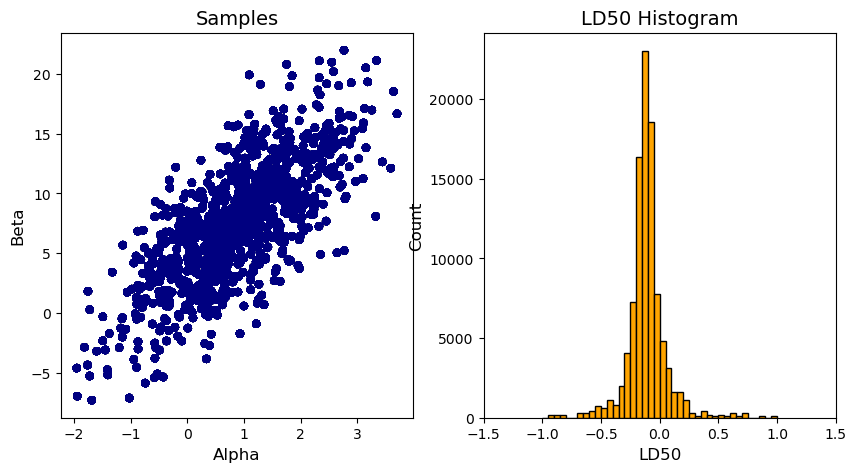

In [7]:
# create the figure and axis objects
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the scatter plot on the first axis
axs[0].scatter(rissamp_A, rissamp_B, alpha=0.5, color='navy', edgecolors='none')
axs[0].set_xlabel('Alpha', fontsize=12)
axs[0].set_ylabel('Beta', fontsize=12)
axs[0].set_title('Samples', fontsize=14)
# axs[0].text(2, 5, 'p(beta>0)={:.2f}'.format(np.mean(samp_acc[:,1]>0)), fontsize=12)

# plot the histogram on the second axis
axs[1].hist(rissamp_ld50, bins=np.arange(-1, 1 + 0.05, 0.05), color='orange', edgecolor='black')
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_xlabel('LD50', fontsize=12)
axs[1].set_ylabel('Count', fontsize=12)
axs[1].set_title('LD50 Histogram', fontsize=14)

plt.show()